<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#mu/sd-for-z-score-transformation" data-toc-modified-id="mu/sd-for-z-score-transformation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>mu/sd for z-score transformation</a></span></li></ul></li><li><span><a href="#Train/Test-split" data-toc-modified-id="Train/Test-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train/Test split</a></span></li><li><span><a href="#Writing" data-toc-modified-id="Writing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Writing</a></span><ul class="toc-item"><li><span><a href="#Train/test" data-toc-modified-id="Train/test-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Train/test</a></span></li></ul></li><li><span><a href="#Hyperparameter-search" data-toc-modified-id="Hyperparameter-search-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Hyperparameter search</a></span><ul class="toc-item"><li><span><a href="#genome_phy" data-toc-modified-id="genome_phy-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>genome_phy</a></span><ul class="toc-item"><li><span><a href="#Config" data-toc-modified-id="Config-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#no_phy" data-toc-modified-id="no_phy-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>no_phy</a></span><ul class="toc-item"><li><span><a href="#Config" data-toc-modified-id="Config-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#random_phy" data-toc-modified-id="random_phy-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>random_phy</a></span><ul class="toc-item"><li><span><a href="#Config" data-toc-modified-id="Config-7.3.1"><span class="toc-item-num">7.3.1&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-7.3.2"><span class="toc-item-num">7.3.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Summary</a></span></li></ul></li></ul></div>

# Goal

* dataset generation for treeSparse algorithm
* target: westernization (binary classification)

# Var

In [24]:
# working dir
work_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/ML/'

# bracken counts
brk_file = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/bracken_filt.qs'

# metadata
## filtered
metadata_filt_file = file.path(work_dir, 'CurMetDat_metadata_filt-n1846.tsv')
## all 
base_in_dir = '/ebio/abt3_projects/small_projects/nyoungblut/public_data_retireval/'
metadata_file = file.path(base_in_dir, 'CurMetDat-metagenomes', 'files', 'metadata', 'Filtered_CurMetDat_f.tsv')

# trees
## GTDB genome phylogeny
phy_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/phylogeny/ar122-bac120_r89_1per-GTDB-Spec_gte50comp-lt5cont_rn.nwk'
## Trait 
phy_trt_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/predictions_flat_majority-votes_combined_jaccard_rn.nwk'
## COG content
phy_cog_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-COG_bray.nwk'
phy_cogcat_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-COGcat_bray.nwk'
## pfam content
phy_pfam_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-pfam_bray.nwk'
phy_pfamcat_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-pfamGrp_bray.nwk'

# params
threads = 8

# Init

In [25]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(ape)
library(LeyLabRMisc)

In [26]:
make_dir(work_dir)
setDTthreads(threads)
df.dims()

Directory already exists: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/ML/ 


# Load

In [27]:
# all 
meta = fread(metadata_file, sep='\t', check.names=TRUE) %>%
    mutate.(Sample = gsub('-', '.', Sample)) %>%
    filter.(number_reads >= 5e5) %>%
    select.(Sample, dataset_name, subjectID, study_condition, 
              disease, age, gender, BMI, westernized)

meta %>% unique_n('Samples', Sample)
meta

No. of unique Samples: 3582 


Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
MV_FEM1_t1Q14,AsnicarF_2017,MV_FEM1,control,healthy,NA,female,NA,TRUE
MV_FEM2_t1Q14,AsnicarF_2017,MV_FEM2,control,healthy,NA,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
CCIS82944710ST.20.0,ZellerG_2014,FR-730,control,healthy,38,female,22,TRUE
CCIS93040568ST.20.0,ZellerG_2014,FR-682,control,healthy,65,male,30,TRUE


In [28]:
# Bracken count table
brk = qs::qread(brk_file, nthreads=threads) %>%
    mutate.(name = gsub(' ', '_', name)) %>%
    filter.(Sample %in% meta$Sample)
brk %>% unique_n('Species', name)
brk %>% unique_n('Samples', Sample)
brk 

No. of unique Species: 3550 
No. of unique Samples: 3348 


dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CosteaPI_2017,s__Caecibacter_massiliensis,108259,S,Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Megasphaeraceae,Caecibacter,Caecibacter massiliensis,halbarad.11.0.0,0
CosteaPI_2017,s__UBA1777_sp002350825,178550,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,UBA1777,UBA1777 sp002350825,halbarad.11.0.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Serratia_grimesii,121568,S,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Serratia,Serratia grimesii,SZAXPI017592.142,0
YuJ_2015,s__Bacteroides_A_sp002161565,119189,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_A,Bacteroides_A sp002161565,SZAXPI017592.142,0


In [29]:
# abundance filtering
min_abund = 0.0005
#min_abund = 0.000001
brk = brk %>%
    mutate.(mean_abund = mean(Abundance), by=c(name)) %>%
    filter.(mean_abund > min_abund) %>%
    mutate.(n_taxa = sum(Abundance > 0), by=c(Sample)) %>%
    filter.(n_taxa > 0) %>%
    select.(-mean_abund, -n_taxa)
brk %>% unique_n('Species', name)
brk %>% unique_n('Samples', Sample)
brk

No. of unique Species: 330 
No. of unique Samples: 3348 


dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CosteaPI_2017,s__Eubacterium_G_ventriosum,141784,S,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,Eubacterium_G ventriosum,halbarad.11.0.0,0.0024
CosteaPI_2017,s__Prevotella_sp000436035,150829,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella sp000436035,halbarad.11.0.0,0.0000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Ruminiclostridium_E_siraeum,113768,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Ruminiclostridium_E,Ruminiclostridium_E siraeum,SZAXPI017592.142,0.00069
YuJ_2015,s__CAG-307_sp001916215,128632,S,Bacteria,Firmicutes,Bacilli,Acholeplasmatales,CAG-307,CAG-307,CAG-307 sp001916215,SZAXPI017592.142,0.00000


In [30]:
# abundances to wide table
m = brk %>%
    select.(name, Sample, Abundance) %>%
    pivot_wider.(name, Abundance) %>%
    as.data.frame 
rownames(m) = m[,1]
m[,1] = NULL
m = m %>% apply(2, function(x) ifelse(is.na(x), 0, x)) %>%
        as.data.frame
m

,s__51-20_sp001917175,s__Acetatifactor_sp900066365,s__Acetatifactor_sp900066565,s__Adlercreutzia_equolifaciens,s__Afipia_birgiae,s__Afipia_broomeae,s__Afipia_clevelandensis,s__Afipia_sp000497575,s__Afipia_sp001897905,s__Agathobacter_faecis,⋯,s__Treponema_D_succinifaciens,s__Tyzzerella_nexilis,s__UBA11524_sp000437595,s__UBA738_sp002404605,s__Vibrio_cholerae,s__Vibrio_metoecus,s__Vibrio_metoecus_B,s__Vibrio_mimicus,s__Vibrio_sp000176715,s__Zag111_sp002103105
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A01_02_1FE,0,0.00204,0.00111,0,0,0,0,0,0,0.03677,⋯,0.00000,0,0,0.00089,0,0,0,0,0,0
A02_01_1FE,0,0.00115,0.00038,0,0,0,0,0,0,0.00434,⋯,0.00324,0,0,0.00000,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
nHMX11726,0,0.08415,0.01837,0e+00,0,0,0,0,0,0.00168,⋯,0,0.00046,0.00463,0.00269,0,0,0,0,0,0
scavenger.11.60.0,0,0.00070,0.00312,6e-04,0,0,0,0,0,0.04413,⋯,0,0.00081,0.00000,0.00000,0,0,0,0,0,0


In [31]:
# metadata filtered
meta_f = meta %>%
    filter.(Sample %in% rownames(m)) %>%
    as.data.frame
rownames(meta_f) = meta_f$Sample
meta_f %>% unique_n('Samples', Sample)
meta_f

No. of unique Samples: 3348 


,Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
MV_FEM1_t1Q14,MV_FEM1_t1Q14,AsnicarF_2017,MV_FEM1,control,healthy,NA,female,NA,TRUE
MV_FEM2_t1Q14,MV_FEM2_t1Q14,AsnicarF_2017,MV_FEM2,control,healthy,NA,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PNP_Validation_45,PNP_Validation_45,ZeeviD_2015,PNP_Validation_45,control,healthy,NA,NA,NA,TRUE
PNP_Validation_46,PNP_Validation_46,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,NA,NA,TRUE


In [32]:
# Genome phylogeny
phy = read.tree(phy_file)
to_rm = setdiff(phy$tip.label, colnames(m))
phy = ape::drop.tip(phy, to_rm)
phy


Phylogenetic tree with 330 tips and 329 internal nodes.

Tip labels:
	s__Methanobrevibacter_A_smithii, s__Methanobrevibacter_A_smithii_A, s__Ruminococcus_E_bromii_B, s__Ruminococcus_E_bromii, s__Ruminococcus_E_sp900314705, s__GCA-900066995_sp900291955, ...
Node labels:
	100.0, 100.0, 1.0, 0.0, 0.0, 3.0, ...

Rooted; includes branch lengths.

In [33]:
# random phylogney
phy_rand = ape::rtree(length(phy$tip.label), tip.label = phy$tip.label)
phy_rand


Phylogenetic tree with 330 tips and 329 internal nodes.

Tip labels:
	s__CAG-95_sp900066375, s__Bifidobacterium_longum, s__Prevotella_sp900313215, s__Prevotellamassilia_timonensis, s__Faecalibacterium_prausnitzii_E, s__Bifidobacterium_kashiwanohense, ...

Rooted; includes branch lengths.

## mu/sd for z-score transformation

In [13]:
brk %>% 
    summarize.(mu = mean(Abundance),
               sd = sd(Abundance))

mu,sd
<dbl>,<dbl>
0.003021272,0.01375474


# Train/Test split

In [14]:
train_frac = 0.8
n_train = round(nrow(meta_f) * train_frac,0)
meta_f_train = meta_f[sample(meta_f$Sample, n_train),]
meta_f_test = meta_f[setdiff(meta_f$Sample, meta_f_train$Sample),]
meta_f_train %>% nrow %>% cat('No. of training samples:', ., '\n')
meta_f_test %>% nrow %>% cat('No. of test samples:', ., '\n')

No. of training samples: 2678 
No. of test samples: 670 


In [15]:
# summary
meta_f_train$westernized %>% summary
meta_f_test$westernized %>% summary

   Mode   FALSE    TRUE 
logical     421    2257 

   Mode   FALSE    TRUE 
logical      97     573 

In [16]:
# parsing abunds
m_train = m[meta_f_train$Sample,]
m_test = m[meta_f_test$Sample,]
m_train %>% nrow %>% cat('No. of training samples:', ., '\n')
m_test %>% nrow %>% cat('No. of test samples:', ., '\n')

No. of training samples: 2678 
No. of test samples: 670 


# Writing

In [17]:
outdir = '/ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized/'
make_dir(outdir)

Directory already exists: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized/ 


In [18]:
outF = file.path(outdir, 'genome_phy.nwk')
write.tree(phy, outF)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized//genome_phy.nwk 


In [19]:
outF = file.path(outdir, 'random_phy.nwk')
write.tree(phy_rand, outF)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized//random_phy.nwk 


## Train/test

In [20]:
outF = file.path(outdir, 'abund_train.tsv')
write_table(m_train, outF, row.names=TRUE)

File written: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized//abund_train.tsv 


In [21]:
outF = file.path(outdir, 'abund_test.tsv')
write_table(m_test, outF, row.names=TRUE)

File written: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized//abund_test.tsv 


In [22]:
outF = file.path(outdir, 'targets_train.tsv')
write_table(meta_f_train, outF, row.names=TRUE)

File written: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized//targets_train.tsv 


In [23]:
outF = file.path(outdir, 'targets_test.tsv')
write_table(meta_f_test, outF, row.names=TRUE)

File written: /ebio/abt3_projects/software/dev/treeSparse/tests/data/globalMG/westernized//targets_test.tsv 


# Hyperparameter search

In [23]:
D = '/ebio/abt3_projects/software/dev/treeSparse/'

## genome_phy

### Config

In [24]:
F = file.path(D, 'hyperparam_search/westernized/genome_phy/config.yaml')
cat_file(F)

#-- I/O --#
input_files:
  train:
    x: tests/data/globalMG/westernized/abund_train.tsv
    y: tests/data/globalMG/westernized/targets_train.tsv
  test:
    x: tests/data/globalMG/westernized/abund_test.tsv
    y: tests/data/globalMG/westernized/targets_test.tsv
  tree: tests/data/globalMG/westernized/genome_phy.nwk

# output location
output_dir: hyperparam_search/westernized/genome_phy/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

#-- set params and search params --#
set_params: --mu 0.003021272 --sigma 0.01375474 --epochs 200
search_params:
  batches:
    - 50
    - 100
    - 200
  distances:
    - 0.05
    - 0.1
    - 0.2
    - 0.5
    - 0.8
    - 0.1 0.3
    - 0.1 0.5
  linear_layers:
    - 500
    - 100
    - 10
    - 500 100
    - 500 20
    - 200 20
  dropout:
    sparse:
      - 0
      - 0.1
      - 0.25
      - 0.5
    linear:
      - 0
      - 0.1
      - 0.25
      - 0.5
  learning_rate:
    - 0.001
    - 0.0001

#--

### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/treeSparse
$ screen -L -S treeSparse-genomePhy snakemake --use-conda -j 24 --configfile hyperparam_search/westernized/genome_phy/config.yaml -F
```

## no_phy

* Using only fully connected linear layers

### Config

In [26]:
F = file.path(D, 'hyperparam_search/westernized/no_phy/config.yaml')
cat_file(F)

#-- I/O --#
input_files:
  train:
    x: tests/data/globalMG/westernized/abund_train.tsv
    y: tests/data/globalMG/westernized/targets_train.tsv
  test:
    x: tests/data/globalMG/westernized/abund_test.tsv
    y: tests/data/globalMG/westernized/targets_test.tsv
  tree: tests/data/globalMG/westernized/genome_phy.nwk

# output location
output_dir: hyperparam_search/westernized/no_phy/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

#-- set params and search params --#
set_params: --mu 0.003021272 --sigma 0.01375474 --epochs 200 --all-linear
search_params:
  batches:
    - 50
    - 100
    - 200
  distances:
    - 0.05
    - 0.1
    - 0.2
    - 0.5
    - 0.8
    - 0.1 0.3
    - 0.1 0.5
  linear_layers:
    - 500
    - 100
    - 10
    - 500 100
    - 500 20
    - 200 20
  dropout:
    sparse:
      - 0
      - 0.1
      - 0.25
      - 0.5
    linear:
      - 0
      - 0.1
      - 0.25
      - 0.5
  learning_rate:
    - 0.001
    - 0.

### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/treeSparse
$ screen -L -S treeSparse-genomePhy snakemake --use-conda -j 24 --configfile hyperparam_search/westernized/no_phy/config.yaml -F
```

## random_phy

* Randomly generated phylogeny instead of genome-phylogeny

### Config

In [27]:
F = file.path(D, 'hyperparam_search/westernized/random_phy/config.yaml')
cat_file(F)

#-- I/O --#
input_files:
  train:
    x: tests/data/globalMG/westernized/abund_train.tsv
    y: tests/data/globalMG/westernized/targets_train.tsv
  test:
    x: tests/data/globalMG/westernized/abund_test.tsv
    y: tests/data/globalMG/westernized/targets_test.tsv
  tree: tests/data/globalMG/westernized/random_phy.nwk

# output location
output_dir: hyperparam_search/westernized/random_phy/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

#-- set params and search params --#
set_params: --mu 0.003021272 --sigma 0.01375474 --epochs 200
search_params:
  batches:
    - 50
    - 100
    - 200
  distances:
    - 0.05
    - 0.1
    - 0.2
    - 0.5
    - 0.8
    - 0.1 0.3
    - 0.1 0.5
  linear_layers:
    - 500
    - 100
    - 10
    - 500 100
    - 500 20
    - 200 20
  dropout:
    sparse:
      - 0
      - 0.1
      - 0.25
      - 0.5
    linear:
      - 0
      - 0.1
      - 0.25
      - 0.5
  learning_rate:
    - 0.001
    - 0.0001

#--

### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/treeSparse
$ screen -L -S treeSparse-genomePhy snakemake --use-conda -j 24 --configfile hyperparam_search/westernized/random_phy/config.yaml -F
```

## Summary

In [30]:
F = c('hyperparam_search/westernized/genome_phy/training_logs/train_log.tsv',
      'hyperparam_search/westernized/no_phy/training_logs/train_log.tsv',
      'hyperparam_search/westernized/random_phy/training_logs/train_log.tsv')

read_file = function(x){
    dt = Fread(x)
    dt$dataset = gsub('.+westernized/([^/]+)/.+', '\\1', x)
    return(dt)
}

train_log = F %>%
    lapply(function(x) file.path(D, x)) %>%
    lapply(read_file) %>%
    data.table::rbindlist(use.names = TRUE)
train_log

batches,distances,linear_layers,dropout_sparse,dropout_linear,learning_rate,epoch,train_loss,test_loss,dataset
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>
50,0.05,500,0,0,0.001,1,0.4095649,0.2758943,genome_phy
50,0.05,500,0,0,0.001,2,0.2184573,0.1869103,genome_phy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
200,0.1-0.5,200-20,0.5,0.5,1e-04,26,0.4409467,0.4503427,random_phy
200,0.1-0.5,200-20,0.5,0.5,1e-04,27,0.4487109,0.4385606,random_phy


In [32]:
# param settings that achieve the lowest test-loss
df.dims(15)
train_log_s = train_log %>%
    mutate.(min_test_loss = min(test_loss),
               by=c(dataset, batches, distances, linear_layers, 
                    dropout_sparse, dropout_linear, learning_rate)) %>%
    filter.(test_loss == min_test_loss)
train_log_s %>%
    arrange.(min_test_loss) %>%
    slice_head.(n=15)
df.dims()

batches,distances,linear_layers,dropout_sparse,dropout_linear,learning_rate,epoch,train_loss,test_loss,dataset,min_test_loss
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>
100,0.05,500-100,0,0.00,0.001,47,0.04262793,0.03500783,genome_phy,0.03500783
50,0.8,500-20,0,0.25,0.001,44,0.04898371,0.03644847,genome_phy,0.03644847
200,0.5,500-100,0,0.10,0.001,55,0.04262130,0.03674702,genome_phy,0.03674702
100,0.05,500-20,0,0.10,0.001,54,0.04235661,0.03684680,genome_phy,0.03684680
50,0.2,500-20,0,0.00,0.001,41,0.04870421,0.03836926,genome_phy,0.03836926
50,0.8,500-100,0,0.00,0.001,38,0.04780601,0.03844544,genome_phy,0.03844544
100,0.1,500-20,0,0.10,0.001,47,0.04468381,0.03886086,random_phy,0.03886086
200,0.2,500-20,0,0.10,0.001,58,0.04741332,0.03894964,random_phy,0.03894964
100,0.2,200-20,0,0.25,0.001,54,0.04790275,0.03896850,genome_phy,0.03896850


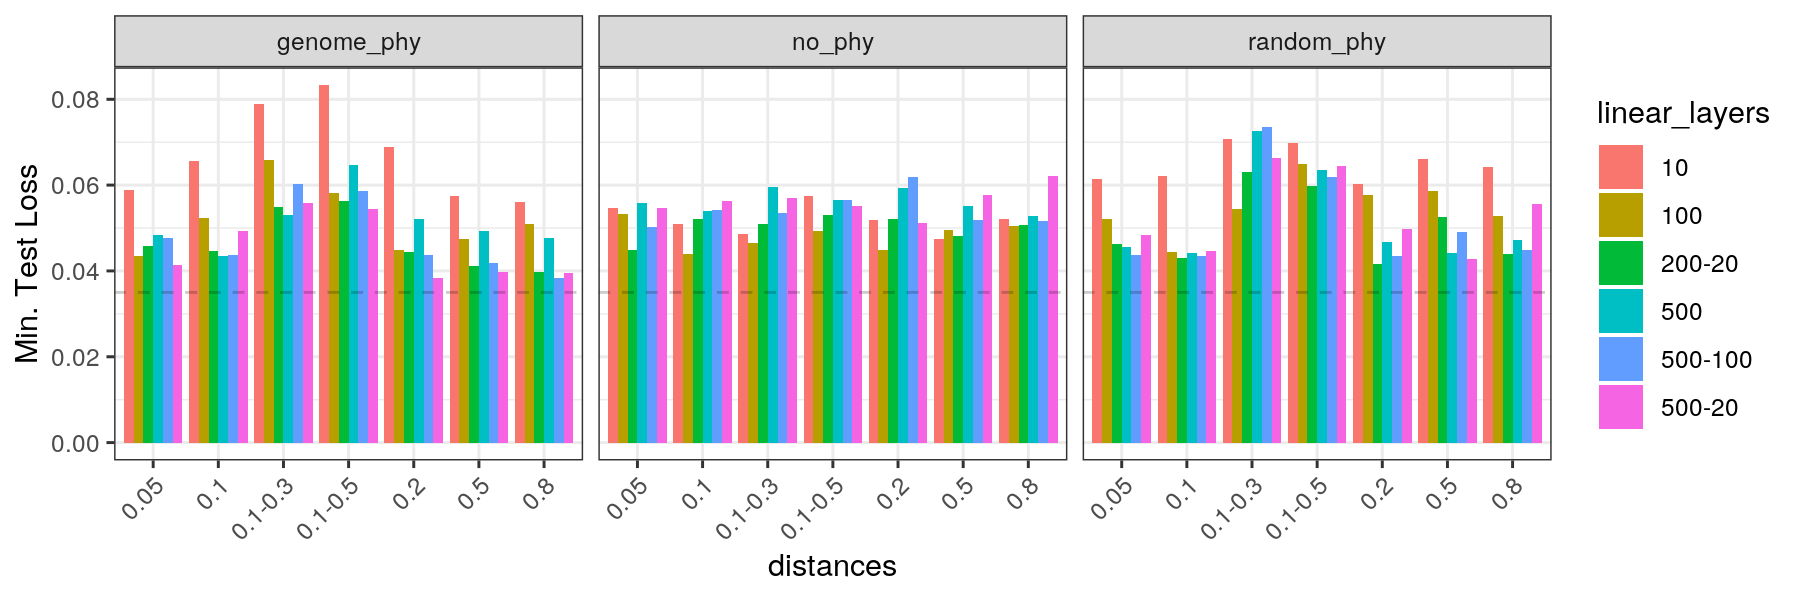

In [33]:
p = train_log_s %>%
    filter(batches == 50,
           learning_rate == 0.001,
           dropout_sparse == 0,
           dropout_linear == 0) %>%
    ggplot(aes(distances, min_test_loss, fill=linear_layers)) +
        geom_bar(stat='identity', position='dodge') +
        geom_hline(yintercept=0.035, alpha=0.2, linetype='dashed') +
        labs(y='Min. Test Loss') +
        facet_wrap(~ dataset) +
        theme_bw() +
        theme(
            axis.text.x = element_text(angle=45, hjust=1)
        )

p.dims(9,3)
plot(p)

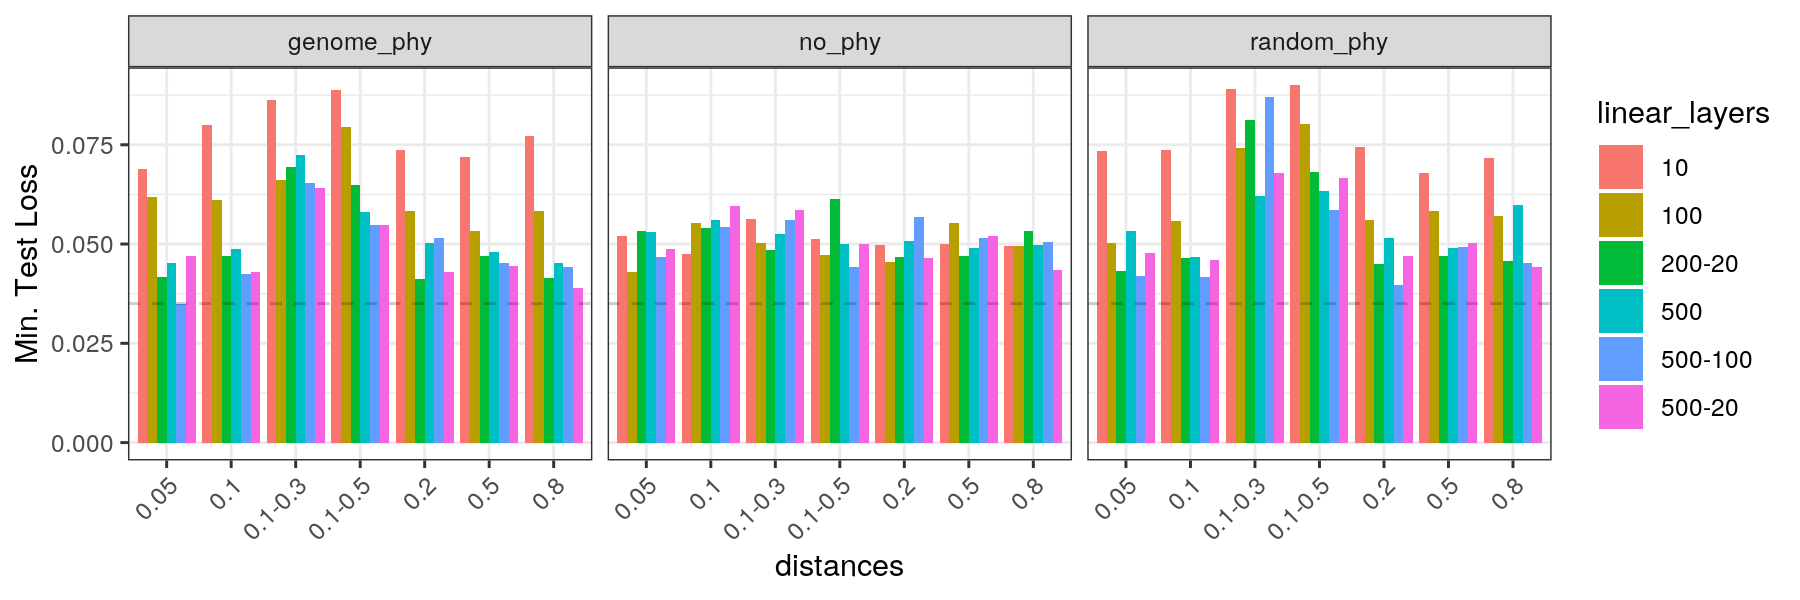

In [35]:
p = train_log_s %>%
    filter(batches == 100,
           learning_rate == 0.001,
           dropout_sparse == 0,
           dropout_linear == 0) %>%
    ggplot(aes(distances, min_test_loss, fill=linear_layers)) +
        geom_bar(stat='identity', position='dodge') +
        geom_hline(yintercept=0.035, alpha=0.2, linetype='dashed') +
        labs(y='Min. Test Loss') +
        facet_wrap(~ dataset) +
        theme_bw() +
        theme(
            axis.text.x = element_text(angle=45, hjust=1)
        )

p.dims(9,3)
plot(p)

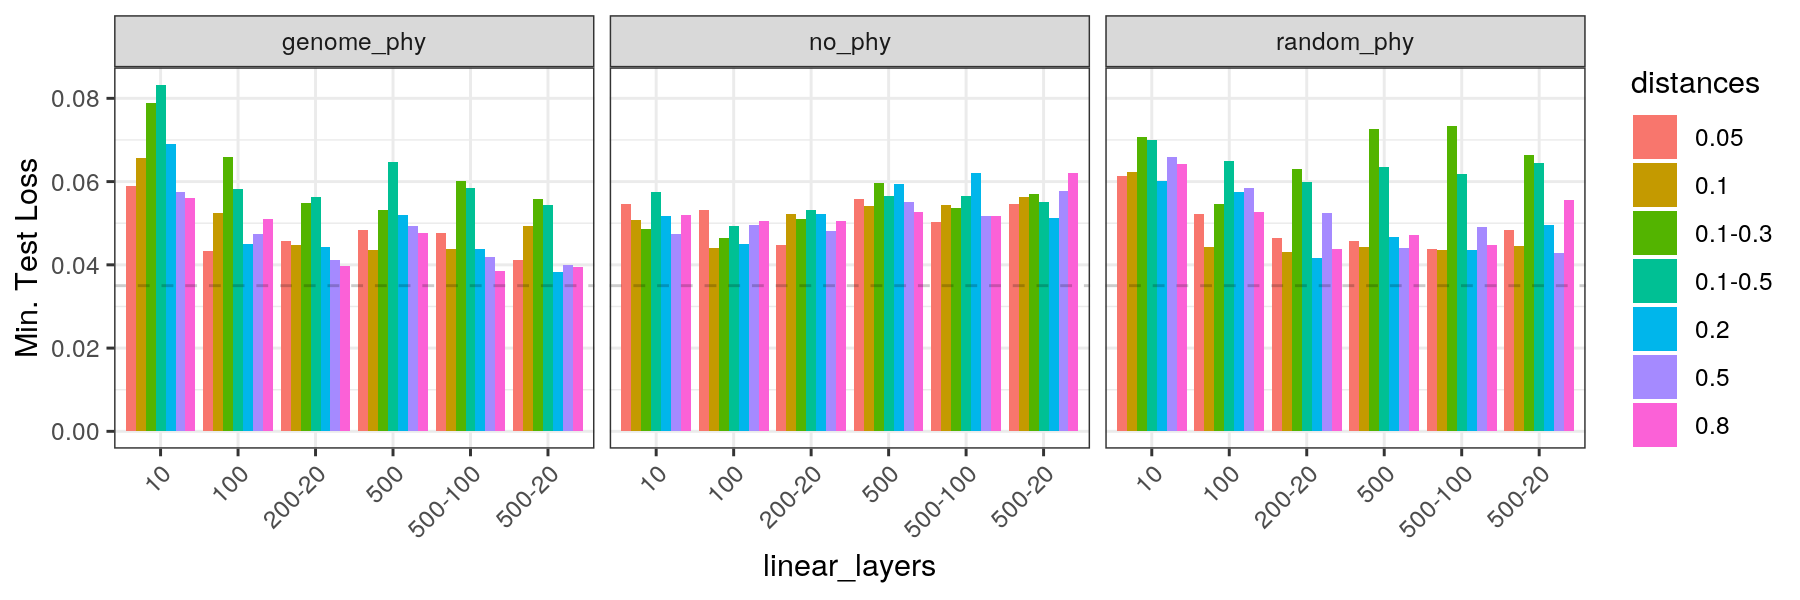

In [43]:
p = train_log_s %>%
    filter(batches == 50,
           learning_rate == 0.001,
           dropout_sparse == 0,
           dropout_linear == 0) %>%
    ggplot(aes(linear_layers, min_test_loss, fill=distances)) +
        geom_bar(stat='identity', position='dodge') +
        geom_hline(yintercept=0.035, alpha=0.2, linetype='dashed') +
        labs(y='Min. Test Loss') +
        facet_wrap(~ dataset) +
        theme_bw() +
        theme(
            axis.text.x = element_text(angle=45, hjust=1)
        )

p.dims(9,3)
plot(p)

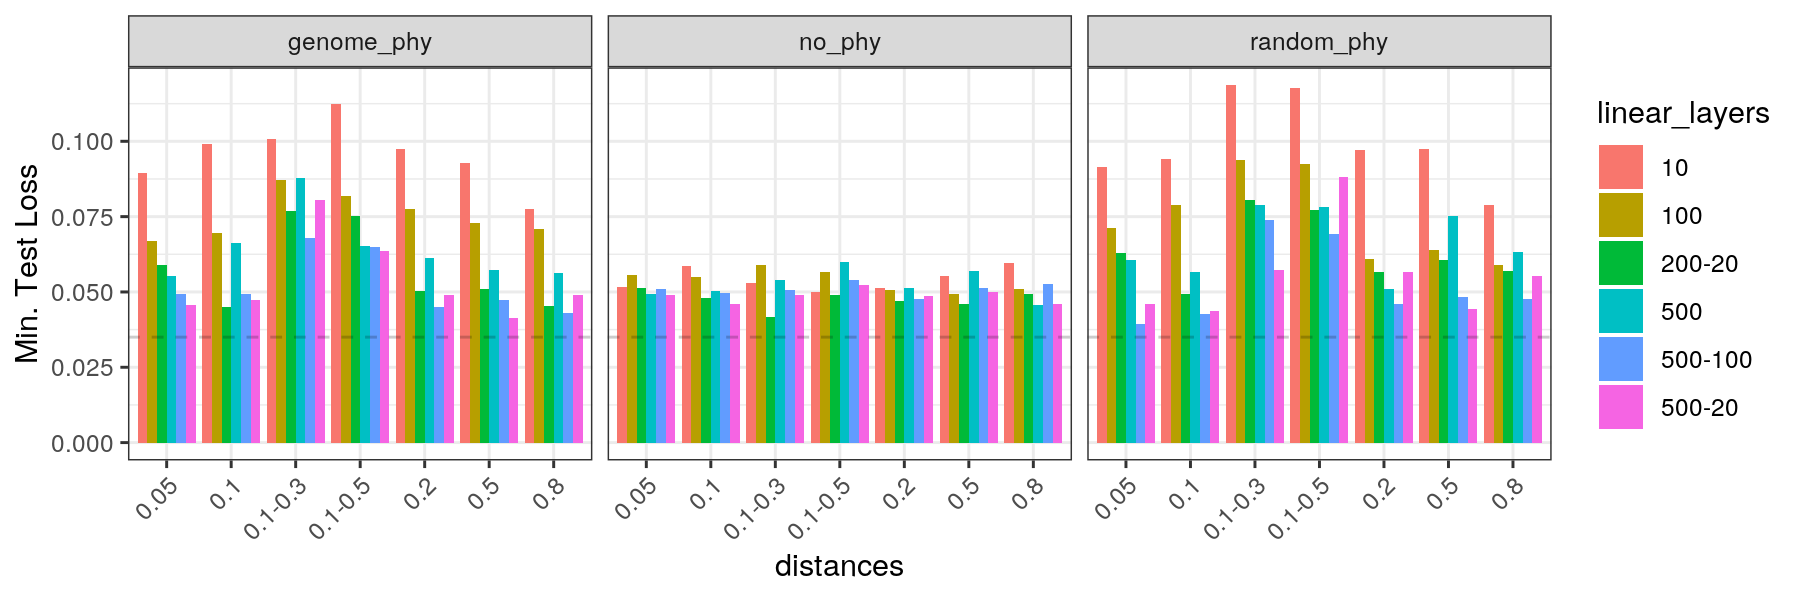

In [34]:
p = train_log_s %>%
    filter(batches == 200,
           learning_rate == 0.001,
           dropout_sparse == 0,
           dropout_linear == 0) %>%
    ggplot(aes(distances, min_test_loss, fill=linear_layers)) +
        geom_bar(stat='identity', position='dodge') +
        geom_hline(yintercept=0.035, alpha=0.2, linetype='dashed') +
        labs(y='Min. Test Loss') +
        facet_wrap(~ dataset) +
        theme_bw() +
        theme(
            axis.text.x = element_text(angle=45, hjust=1)
        )

p.dims(9,3)
plot(p)

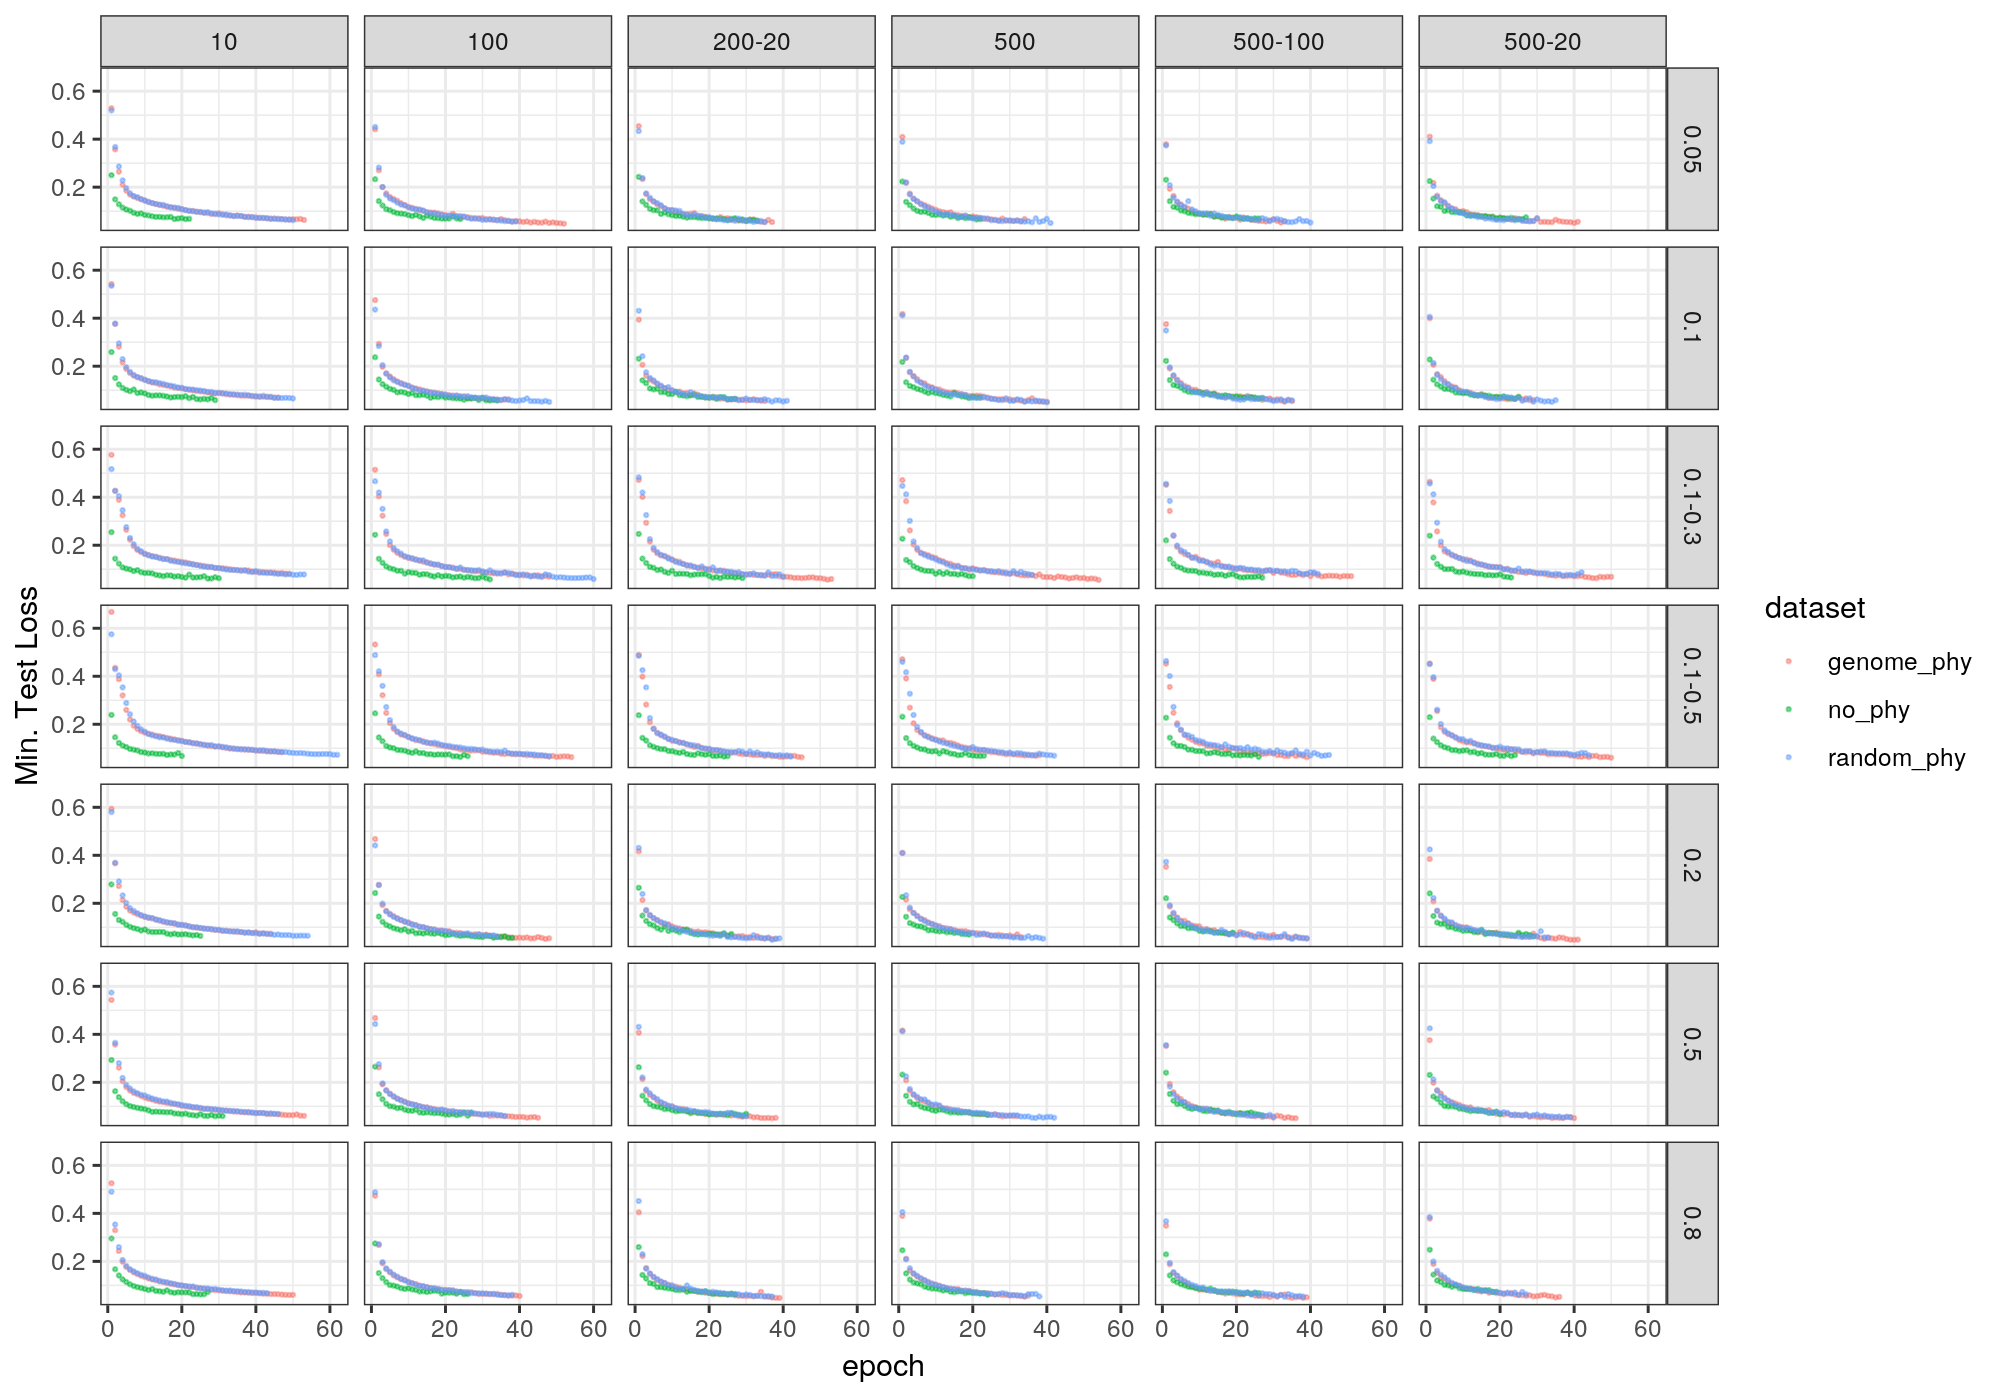

In [42]:
p = train_log %>%
    filter(batches == 50,
           learning_rate == 0.001,
           dropout_sparse == 0,
           dropout_linear == 0) %>%
    ggplot(aes(epoch, train_loss, color=dataset)) +
        geom_point(size=0.4, alpha=0.5) +
        labs(y='Min. Test Loss') +
        facet_grid(distances ~ linear_layers) +
        theme_bw()

p.dims(10,7)
plot(p)